## 1.Word2Vec
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

## 2.필요 패키지 import

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

## 3.데이터 전처리


데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.

In [ ]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

In [ ]:
tokenizer = Okt()

In [ ]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    tokens = tokenizer.morphs(sent, stem=True)
    tokenized.append(tokens)

  return tokenized

In [ ]:
train_tokenized = make_tokenized(train_data)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [ ]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 32589.77it/s]


In [ ]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [ ]:
w2i = {}
for pair in tqdm(word_count):
  if pair[0] not in w2i:
    w2i[pair[0]] = len(w2i)

i2w={v:k for k,v in w2i.items()}

100%|██████████| 60/60 [00:00<00:00, 273839.22it/s]


In [ ]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

## 4.Skipgram과 CBow

* Cbow는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [ ]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.y.append(id)

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.x += [id] * 2 * window_size

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [ ]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 19373.23it/s]


[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

## 5.모델 Class 구현

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [ ]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [ ]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim):
    super(SkipGram, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

두 가지 모델을 생성합니다.

In [ ]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

## 6.모델 학습

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [ ]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [ ]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(cbow_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

    print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:01<00:00, 15.39it/s]


Train loss: 4.770500183105469
Train loss: 4.639904022216797
Train loss: 4.3916449546813965
Train loss: 4.256136894226074
Train loss: 3.943558931350708
Train loss: 5.164700984954834
Train loss: 5.576388359069824
Train loss: 4.642991065979004
Train loss: 4.567241191864014
Train loss: 4.157295227050781
Train loss: 4.937369346618652
Train loss: 4.037747383117676
Train loss: 4.915029048919678
Train loss: 4.527275085449219
Train loss: 4.874154090881348
Train loss: 5.247368812561035
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 377.00it/s]


Train loss: 4.585297107696533
Train loss: 4.515359878540039
Train loss: 4.270790100097656
Train loss: 4.139678955078125
Train loss: 3.8256897926330566
Train loss: 4.8543829917907715
Train loss: 5.381721019744873
Train loss: 4.529167175292969
Train loss: 4.437054634094238
Train loss: 3.969395637512207
Train loss: 4.743492603302002
Train loss: 3.6881155967712402
Train loss: 4.754703521728516
Train loss: 4.4182963371276855
Train loss: 4.736697196960449
Train loss: 5.11727237701416
##################################################
Epoch: 3


100%|██████████| 16/16 [00:00<00:00, 447.76it/s]


Train loss: 4.403616905212402
Train loss: 4.392886161804199
Train loss: 4.15130615234375
Train loss: 4.024877548217773
Train loss: 3.709963798522949
Train loss: 4.5604777336120605
Train loss: 5.191092014312744
Train loss: 4.417228698730469
Train loss: 4.314041614532471
Train loss: 3.7876577377319336
Train loss: 4.563947677612305
Train loss: 3.367966890335083
Train loss: 4.597459316253662
Train loss: 4.311182022094727
Train loss: 4.600639820098877
Train loss: 4.989142417907715
##################################################
Epoch: 4


100%|██████████| 16/16 [00:00<00:00, 417.39it/s]


Train loss: 4.225425720214844
Train loss: 4.272505283355713
Train loss: 4.033234119415283
Train loss: 3.911778450012207
Train loss: 3.596384286880493
Train loss: 4.283260345458984
Train loss: 5.004370212554932
Train loss: 4.307151794433594
Train loss: 4.197587490081787
Train loss: 3.6125097274780273
Train loss: 4.399082183837891
Train loss: 3.0784902572631836
Train loss: 4.443304061889648
Train loss: 4.20591926574707
Train loss: 4.466032981872559
Train loss: 4.862945556640625
##################################################
Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 4.050726413726807
Train loss: 4.154238700866699
Train loss: 3.916618824005127
Train loss: 3.800426483154297
Train loss: 3.484959125518799
Train loss: 4.022838592529297


100%|██████████| 16/16 [00:00<00:00, 33.63it/s]

Train loss: 4.821461200714111
Train loss: 4.1989240646362305
Train loss: 4.08690071105957
Train loss: 3.444211959838867
Train loss: 4.248754501342773
Train loss: 2.8195836544036865
Train loss: 4.292239665985107
Train loss: 4.102494716644287
Train loss: 4.332937240600586
Train loss: 4.738665580749512
Finished.


다음으로 Skip-gram 모델 학습입니다.

In [ ]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(skipgram_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 64/64 [00:00<00:00, 715.26it/s]


Train loss: 4.487279891967773
##################################################
Epoch: 2


100%|██████████| 64/64 [00:00<00:00, 565.62it/s]


Train loss: 4.423480033874512
##################################################
Epoch: 3


100%|██████████| 64/64 [00:00<00:00, 648.73it/s]


Train loss: 4.360193252563477
##################################################
Epoch: 4


100%|██████████| 64/64 [00:00<00:00, 493.01it/s]


Train loss: 4.2974371910095215
##################################################
Epoch: 5


100%|██████████| 64/64 [00:00<00:00, 798.92it/s]

Train loss: 4.2352294921875
Finished.


## 7.테스트

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [ ]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 음식
tensor([ 1.6362, -0.5743, -0.5861, -0.5066,  0.1445, -1.3277, -1.4867,  0.6725,
         0.7046,  0.6438, -0.0940, -0.7049,  0.6756,  0.7585,  1.1848, -1.2823,
         0.4941,  0.6595,  0.1902, -1.3971,  1.1360,  0.0964, -1.8118, -0.3862,
        -0.2860,  1.6513, -1.0786, -0.3636, -1.2490, -0.6488,  0.4602, -1.6475,
         0.0415,  1.1131, -0.6265, -0.3940, -1.6145, -0.7022,  0.2177,  0.6715,
        -0.8387, -1.2748, -0.0897, -1.2482,  2.3052,  1.8032, -1.0805, -0.4309,
         0.6292,  0.3377,  0.2157, -0.2789, -0.3059,  1.3397, -0.8382, -0.5754,
         1.1303, -0.9943,  0.6756,  0.6771,  0.3794,  0.5198, -2.6126,  1.8944,
        -0.0909,  0.6811, -1.2399,  0.5333, -1.3525,  0.0475, -2.1436,  1.4260,
         1.1858, -0.2140,  0.4427,  0.7509,  1.1564,  2.1992, -0.2359, -0.4288,
        -0.6077, -2.5207, -0.3458, -0.8464,  2.1449,  0.3015, -0.0517, -0.9778,
         0.0777, -0.8687, -0.6717,  1.9844,  0.3006, -0.2880, -0.7656,  0.4064,
        -1.4792, -0.1986, -0.01

In [ ]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 음식
tensor(2.7168, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.9636, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(2.4929, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(2.4571, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(3.2765, device='cuda:0', grad_fn=<UnbindBackward0>)


In [ ]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [ ]:
i2w[25]

'다시'

In [ ]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [ ]:
most_similar("가격")

['별로', '생각', '것', '드네']

## 8.Word2Vec 시각화

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='NanumBarunGothic') 
#plt.rc('font', family='AppleGothic') #맥

In [ ]:
pca=PCA(n_components=2)

In [ ]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


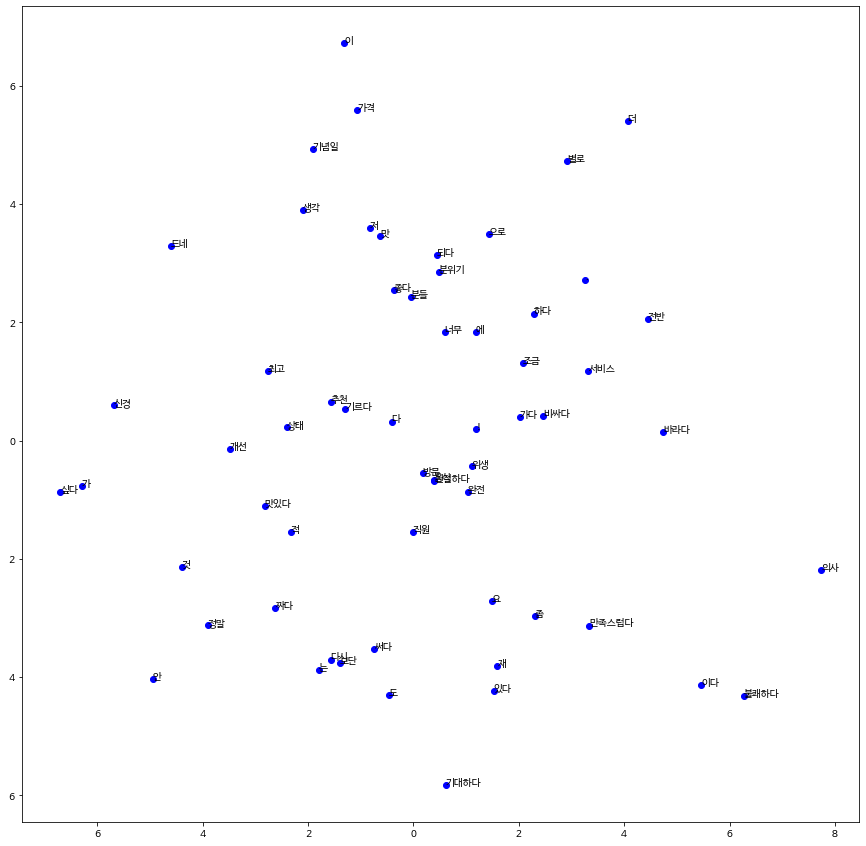

In [ ]:
plt.figure(figsize=(15,15))

for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate, y_coordinate))